

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query("group == 'control' & landing_page == 'new_page'").shape[0] + df.query("group == 'treatment' & landing_page == 'old_page'").shape[0] 

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [9]:
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]['user_id'].unique()

array([773192])

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.duplicated(['user_id'], keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(['user_id'], keep = 'first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query("landing_page == 'new_page'")['user_id'].count()/df2.shape[0]

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on the current conversion data thus far, it does not seem that the new treatment page leads to more conversions but rather slightly less conversions. The conversion rate for the control group and the old page is 12.03% while the conversion rate for the treatment group and the new page is slightly lower at 11.88%.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**My null hypothesis would be that the difference between $p_{new}$ - $p_{old}$ is less than or equal to $p_{old}$.** 

**My alternative hypothesis would be that $p_{new}$ - $p_{old}$ is greater than $p_{old}$.**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

In [21]:
p_new - p_old

0.0

In [22]:
df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()

-0.0015782389853555567

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2[df2['group'] == 'treatment']['user_id'].count()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2['group'] == 'control']['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17242

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17620

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
(new_page_converted/n_new) - (old_page_converted/n_old)

-0.0026313837296570025

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    obs_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
    p_diffs.append(obs_diff)
    
    

In [29]:
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

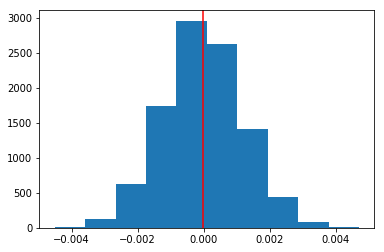

In [30]:
plt.hist(p_diffs);
plt.axvline(p_diffs.mean(), color = 'r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
treatment_conv = df2[df2['group'] == 'treatment']['converted'].mean()
control_conv = df2[df2['group'] == 'control']['converted'].mean()
ab_actual_diff = treatment_conv - control_conv
ab_actual_diff

-0.0015782389853555567

In [32]:
(p_diffs > ab_actual_diff).mean()

0.90439999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part 

**j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The previous value that was returned essentially states what proportion of all the simulated differences in conversion rates, calculated as $p_{new}$ - $p_{old}$, is greater than the actual observed difference of conversion rates between the new page conversion rate and the old page conversion rate.**

**In scientific studies this is called the p-value, which is defined as the probability of obtaining the observed statistic or a greater extereme  under the assumption that the null hypothesis is true.**

**Large p-values suggest that I shouldn't move away from the null hypothesis. Essentially, large are in favor of and validate the null hypothesis. The observed p-value in this case is .907, which is very much in favor of _NOT_ rejecting the null hypothesis.**

**The new landing page DOES NOT lead to a greater conversion rate.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [34]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)].shape[0]
convert_new = df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)].shape[0]
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score_stat, pval = sm.stats.proportions_ztest([convert_old, convert_new],
                                                [n_old, n_new], alternative = 'larger')
print('Z-Score:', z_score_stat)
print('P-value:', pval)

Z-Score: 1.31092419842
P-value: 0.094941687241


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [36]:
# import norm from scipy.stats to find out the significance of the z-score
from scipy.stats import norm
norm.cdf(z_score_stat)


0.90505831275902449

In [37]:
# critical value for 95% confidence
norm.ppf(1-(0.05))

1.6448536269514722

**With a critical z-score value at 95% confidence of 1.6448 and an actual z-score of 1.3109, the computed z-score is lower than the critical z-score and thus fails to reject the null hypothesis. Essentially validating that the new landing page does not leading to a higher conversion rate. The findings here align with the findings in parts J and K.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since each row is either a conversion or no conversion, a scenario of  binary outcomes, the best regression approach to use would be logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-10 18:11 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The p-value associated with the AB page is .190. It differs from the value from part II because part II is a one-tailed test whereas part III is a two-tailed test.**

**The null and alternative hypothesis for this test can be structered as:**

>**$H_{0}$:  P$_{new}$ = P$_{old}$**

>**$H_{1}$:  P$_{new}$ $\neq$ P$_{old}$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding in other factors to my regression model can be beneficial in that the additional factors might better help predict the response variable. Added factors might strengthen and make the model more complete and predictive.**

**However, there are disadvantages with adding variables/factors that might influence whether or not an individual converts. A possible drawback is that I run the risk of multicollinearity, wherein the explanatory variables within the model are related to each other. Ideally, I'd want the explanatory variables and the response variables to be related to each other but not have the  explanatory variables be inter-related.**

**Dimensionality can be useful for obtaining a better understanding of what influences more accurate predictive modeling but it also means the sample size that is needed can become much larger**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns.

In [42]:
df_cntry = pd.read_csv('countries.csv')
df_cntry.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
df_cntry[['CA', 'UK', 'US']] = pd.get_dummies(df_cntry.country)

In [44]:
df3 = df_cntry.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')

In [45]:
df3.reset_index(inplace = True)

In [46]:
df3.head()

,user_id,country,CA,UK,US,timestamp,group,landing_page,converted,intercept,control,ab_page
0,834778,UK,0,1,0,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
1,928468,US,0,0,1,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
2,822059,UK,0,1,0,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
3,711597,UK,0,1,0,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
4,710616,UK,0,1,0,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [47]:
logit_rm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results = logit_rm.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [49]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-10 18:11 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [52]:
print('US Visitors Multiplicative Change:', np.exp(0.0408))
print('UK Visitors Multiplicative Change:', np.exp(0.0506))

US Visitors Multiplicative Change: 1.04164375596
UK Visitors Multiplicative Change: 1.0519020483


**US site visitors are 1.04 times as likely to convert, holding all else constant. Whereas UK site visitors are are 1.05 times are likely to convert, holding all eslse constant.**

**There doesn't appear to be a drastic difference in converson based on where web page traffic is coming from based on country location with how nearly equal the likelihood of conversion is for each country is.**

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0